In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from util_generate_raw_data import generate_raw_data
from siamese_network_func import generate_train_val_test_siamese, create_base_model, create_siamese_model
from util_model_evaluation import get_model_evaluation

Create dataset for Siamese neural network

In [2]:
POS_VEC_LEN = 50
MAX_INT_IDX = 5000

lst_of_files = ['train_kaggle.csv', 'train_glue.tsv', 'dev_glue.tsv']
df = generate_raw_data(*lst_of_files)
X, y = df.drop('is_duplicate', axis = 1), df['is_duplicate']
X_train_q1, X_val_q1, X_test_q1, X_train_q2, X_val_q2, X_test_q2, y_train, y_val, y_test \
    = generate_train_val_test_siamese(X, y, POS_VEC_LEN, MAX_INT_IDX)

train set dimensions:  (808566, 6)
train set dimensions after dropping duplicates by question pair:  (404290, 6)
train set dimensions after dropping duplicates by qid pair:  (404290, 6)


Train Siamese neural network

In [ ]:
tf.random.set_seed(42)
# Create and compile the model
base_model = create_base_model((POS_VEC_LEN,), MAX_INT_IDX)
siamese_model = create_siamese_model(base_model, (POS_VEC_LEN,))
siamese_model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])
# Train the model
siamese_model.fit([X_train_q1, X_train_q2], y_train, epochs = 5, batch_size = 8, validation_data = ([X_val_q1, X_val_q2], y_val))

Make predictions using Siamese neural network

c:\Users\User\AppData\Local\Programs\Python-3.10.16\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1264/1264 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


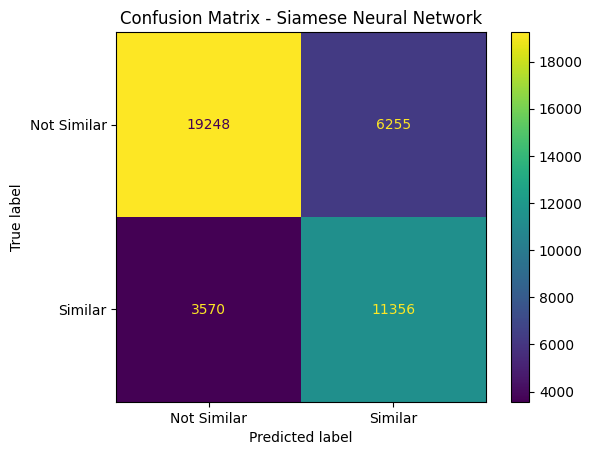

              precision    recall  f1-score   support

 Not Similar       0.84      0.75      0.80     25503
     Similar       0.64      0.76      0.70     14926

    accuracy                           0.76     40429
   macro avg       0.74      0.76      0.75     40429
weighted avg       0.77      0.76      0.76     40429

Accuracy: 0.757
Recall: 0.761
Precision: 0.645
F1-score: 0.698


{'accuracy': 0.757, 'recall': 0.761, 'precision': 0.645, 'f1': 0.698}

In [4]:
siamese_model.load_weights('models/siamese_network_weights.weights.h5')

# Generate predictions and converting probabilities to binary class labels
predictions = siamese_model.predict([X_test_q1, X_test_q2])
predicted_labels = (predictions > 0.5).astype(int)
# Get true labels and convert tensor to numpy array
true_labels = y_test.numpy()
labels = ["Not Similar", "Similar"]
# Print detailed classification report
get_model_evaluation(true_labels, predicted_labels, labels, 'Siamese Neural Network')

Save the model for future use

In [5]:
# Save model weights after training
siamese_model.save_weights('models/siamese_network_weights.weights.h5')